# Trajectory Optimization Comparative Study

In [1]:
# python libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# pydrake imports
from pydrake.all import (
    AddUnitQuaternionConstraintOnPlant,
    AutoDiffXd,
    BasicVector,
    ConstantVectorSource,
    DiagramBuilder,
    DirectTranscription,
    DirectCollocation,
    LogVectorOutput,
    MathematicalProgram,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    Propeller,
    PropellerInfo,
    Quaternion,
    QuaternionEulerIntegrationConstraint,
    RigidTransform,
    RollPitchYaw_,
    RigidTransform_,
    RotationMatrix,
    Simulator,
    SymbolicVectorSystem,
    Solve,
    SnoptSolver,
    UnitQuaternionConstraint,
    Variable,
)

from pydrake.examples import QuadrotorPlant

from underactuated import ConfigureParser
from underactuated.scenarios import AddFloatingRpyJoint

# increase default size matplotlib figures
from matplotlib import rcParams

rcParams["figure.figsize"] = (8, 5)

## Problem Description

In this problem we'll solve for trajectories that efficiently navigate a drone from through a forest, while avoiding a random initialization of trees.
We'll make a few simplifying assumptions about the world we're in:
- the forest is 2D,
- the trees are point masses and do not move.

## Model of the 2D Universe

Let's start by setting up the quadrotor. We will make use of the QuadrotorPlant class from drake, and instantiate both a regular version and an AutoDiff version to support the operations of a Mathematical Program. We also initialize the contexts for both variants here.

In [2]:
def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant = builder.AddSystem(MultibodyPlant(0.0))
    parser = Parser(plant)
    ConfigureParser(parser)
    (model_instance,) = parser.AddModelsFromUrl(
        "package://drake/examples/quadrotor/quadrotor.urdf"
    )
    # By default the multibody has a quaternion floating base.  To match
    # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
    # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
    # instead of ṙ, ṗ, ẏ.
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )
    plant.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = plant.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")

    return builder.Build(), plant

# quadrotor = QuadrotorPlant() 
# quadrotor_ad = quadrotor.ToAutoDiffXd()
# quadrotor_context = quadrotor.CreateDefaultContext()
# quadrotor_context_ad = quadrotor_ad.CreateDefaultContext()
quadrotor, mbp = MakeMultibodyQuadrotor()
quadrotor_ad = quadrotor.ToAutoDiffXd()
mbp_ad = mbp.ToAutoDiffXd()
quadrotor_context = quadrotor.CreateDefaultContext()
mbp_context = mbp.CreateDefaultContext()
quadrotor_context_ad = quadrotor_ad.CreateDefaultContext()
mbp_context_ad = mbp_ad.CreateDefaultContext()

In [3]:
state_dim = mbp.get_state_output_port().size()
# input_dim = quadrotor.get_input_port().size()
input_dim = mbp.get_input_port(5).size()

print("state dim: ", state_dim)
print("input_dim: ", input_dim)

state dim:  12
input_dim:  6


Now it's time to code the `Tree` class and our `forest`. The `Tree` class has a parameter called `radius`, which outlines the size of the tree trunk. The variable `forest_edge_length` simply defines the size of our forest environment.

In [4]:
# 🌲🌲🌲 Forest params 🌲🌲🌲
# np.random.seed(5)
np.random.seed(4)
forest_edge_length = 50
tree_max_size = 4
tree_buffer = 1

In [5]:
# Each tree in the problem is an instance of this class
class Tree(object):
    def __init__(
        self,
        name,  # string with the name of the tree
        color,  # color of the tree for plots
        position,  # position of the tree in the 2d forest in m
        radius,  # radius of the tree in m
    ):
        self.name = name
        self.color = color
        self.position = position
        self.radius = radius
        
def intersects_other_trees(subforest, new_tree):
    for tree in subforest:
        if np.linalg.norm(tree.position - new_tree.position) <= tree.radius + new_tree.radius + tree_buffer:
            return True
    return False

# trees with random data in random positions 🌲
n_trees = 90
forest = []
for i in range(n_trees):
    tree_from_zero = np.random.uniform(size=2) * forest_edge_length
    new_tree = Tree(f"Tree_{i}", "green", tree_from_zero, np.random.random()*tree_max_size)
    while intersects_other_trees(forest, new_tree):
        tree_from_zero = np.random.uniform(size=2) * forest_edge_length
        new_tree = Tree(f"Tree_{i}", "green", tree_from_zero, np.random.random()*tree_max_size)
    forest.append(new_tree)

# for i in range(n_trees):
#     tree_from_zero = np.random.uniform(size=2) * forest_edge_length
#     forest.append(Tree(f"Tree_{i}", 
#                         "green", 
#                         tree_from_zero, 
#                         np.random.random))
    

Now we put all the pieces together in our 2D universe. The class `Universe` also implements some utility functions that will be helpful when setting up the optimization problem. For example, the `quadrotor_discrete_dynamics` function will be relevant for our `direct_shooting` implementation.

In [6]:
# UNIVERSE CLASS 🌌
# contains the quadrotor and forest (collection of Tree objs) 
# implements utility functions needed to write the trajopt
class Universe(object):
    def __init__(
        self,
        quadrotor, # quadrotor instance
        forest,  # list of instances of Tree objects
        start, # quadrotor initial state
        end # quadrotor final state
    ):
        # store data
        self.quadrotor = quadrotor
        self.forest = forest
        self.start = start
        self.end = end

    # given the tree name, returns the Tree instance
    def get_tree(self, name):
        # loop through the trees in the universe
        for tree in self.forest:
            if tree.name == name:
                return tree

        # in case tree has the given name
        print(name + " is not in the Universe!")

    # computes 2D distance vector between the quadrotor and a tree,
    def position_wrt_tree(self, state, name):
        tree = self.get_tree(name)
        pos = state[:2] - tree.position
        
        return pos

    # implement discrete dynamics
    def quadrotor_discrete_dynamics(self, state_t, input_vector, time_interval):

        # get the right instance of plant and context
        mbp_plant = (mbp_ad if isinstance(input_vector[0], AutoDiffXd) else mbp)
        mbp_plant_context = (mbp_context_ad if isinstance(input_vector[0], AutoDiffXd) else mbp_context)
        quadrotor_plant = (quadrotor_ad if isinstance(input_vector[0], AutoDiffXd) else quadrotor)
        quadrotor_plant_context = (quadrotor_context_ad if isinstance(input_vector[0], AutoDiffXd) else quadrotor_context)

        # set the state and input vectors
        mbp_plant_context.SetContinuousState(state_t) # if using generalized forces
        mbp_plant.get_input_port(5).FixValue(mbp_plant_context, input_vector) #if using generalized forces
        # quadrotor_plant_context.SetContinuousState(state_t) # if using propellor inputs
        # quadrotor_plant.get_input_port().FixValue(quadrotor_plant_context, input_vector) # if using propellor inputs
        # print(f"current state: {state_t}")
        # print(f"current input: {input_vector}")

        # implicit-Euler state update
        state_t_dot = mbp_plant.EvalTimeDerivatives(mbp_plant_context) #if using generalized forces
        # state_t_dot = quadrotor_plant.EvalTimeDerivatives(quadrotor_plant_context) # if using propellor inputs

        return state_t + time_interval * state_t_dot.CopyToVector()


# state - x, y, z, phi, theta, psi, x_dot, y_dot, z_dot phi_dot, theta_dot, psi_dot
# state - x, y, z, quatw, quatx, quaty, quatz, xdot, ydot, zdot, quat1dot, quat2dot, quat3dot
start = np.array([5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# start = np.array([ 2.47726077e+01,  2.94914898e+01,  0.00000000e+00,  1.67307611e+00,
#  -3.87075780e+00, -2.45247434e+00,  1.97724302e+00,  1.96502943e+00,
#  -1.73472348e-18, -8.36538053e+00,  1.93537890e+01,  1.22623717e+01])
end = np.array([30, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# end = np.array([9.16025344, 7.77349803, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
forest = forest
universe = Universe(quadrotor, forest, start, end)

## Plot Functions

Here are some plot functions that will help us visualizing the results. There's functionality for plotting the forest, the quadrotor trajectory, and the input trajectory.

In [7]:
# plots a circle centered at a given point with a given radius
def plot_circle(center, radius, *args, **kwargs):
    # discretize angle
    angle = np.linspace(0, 2 * np.pi)

    # plot circle
    plt.plot(
        center[0] + radius * np.cos(angle),
        center[1] + radius * np.sin(angle),
        *args,
        **kwargs
    )

def plot_forest(universe):
    ax = plt.gca()
    ax.set_xlim([0, forest_edge_length])
    ax.set_ylim([0, forest_edge_length])
    ax.set_aspect('equal')
    plt.grid(True)

    # plot Trees
    for tree in universe.forest:
        circle = plt.Circle(tree.position, tree.radius, color=tree.color, alpha = 0.5)
        ax.add_patch(circle)

        circle_buffer = plt.Circle(tree.position, tree.radius + tree_buffer, color="blue", alpha = 0.1)
        ax.add_patch(circle_buffer)
        # plt.text(*tree.position, tree.name)

    start = plt.Circle(universe.start[:2], 0.5, color="blue") 
    stop = plt.Circle(universe.end[:2], 0.5, color="red") 
    plt.text(*universe.start[:2], "start")
    plt.text(*universe.end[:2], "stop")
    ax.add_patch(start)
    ax.add_patch(stop)

# draw the 2D trajectory of the quadrotor with trees
def plot_state_trajectory(universe, trajectory):
    # plot quadrotor trajectory
    # plt.plot(
    #     trajectory[0], trajectory[1], color="k", label="Quadrotor trajectory"
    # )
    plt.scatter(trajectory[0], trajectory[1], color="k", s=1, label="Quadrotor trajectory")
    plt.scatter(trajectory[0, 0], trajectory[1, 0], color="k")

    # plot forest
    plot_forest(universe)

    # misc settings
    plt.xlabel("Meters [m]")
    plt.ylabel("Meters [m]")
    plt.grid(True)
    plt.gca().set_aspect("equal")

    # legend
    n_legend = len(plt.gca().get_legend_handles_labels()[0])
    plt.legend(
        loc="upper center",
        ncol=int(n_legend / 2),
        bbox_to_anchor=(0.5, 1.25),
        fancybox=True,
        shadow=True,
    )


# function that plots the norm of the quadrotor inputs and
# velocity normalized on their maximum value
# TODO: look into using this function (ex. plot_rocket_limits(rocket, thrust_opt, state_opt)) -- see og orbital_transfer nb for more detail
def plot_quadrotor_limits(quadrotor, thrust, state):
    # reconstruct time vector
    time_steps = thrust.shape[0]
    time = np.linspace(0, time_steps, time_steps + 1)

    # plot maximum norm limit
    plt.plot(time, np.ones(time_steps + 1), "r--", label="Limit")

    # plot normalized thrust
    thrust_norm = [np.linalg.norm(t) / quadrotor.thrust_limit for t in thrust]
    plt.step(
        time, [thrust_norm[0]] + thrust_norm, label="Thrust / thrust limit"
    )

    # plot normalized velocity
    velocity_norm = [
        np.linalg.norm(v) / quadrotor.velocity_limit for v in state[:, 2:]
    ]
    plt.plot(time, velocity_norm, label="Velocity / velocity limit")

    # plot limits
    plt.xlim(0, time_steps)
    ymax = max(1, max(thrust_norm), max(velocity_norm)) * 1.05
    plt.ylim(0, ymax)

    # misc settings
    plt.xlabel("Time step")
    plt.grid(True)
    plt.legend()

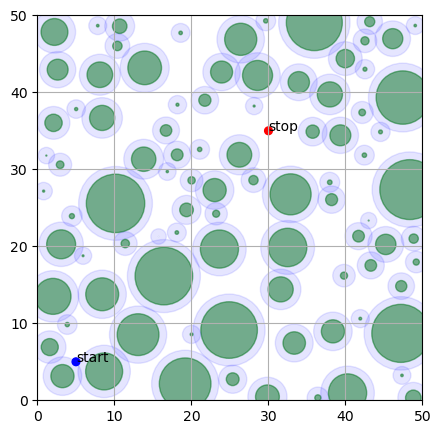

In [8]:
# plot environment
plt.figure()
plot_forest(universe)

In [9]:
def deviation_from_optimal(traj):
    """
    traj: trajectory of 6 states
    start: overall start
    end: overall end goal
    """
    optimal_dist = np.linalg.norm(traj[0:3, -1]-traj[0:3, 0])

    trial_dist = 0
    for i in range(traj.shape[1]-1):
        trial_start = traj[0:3, i]
        trial_end = traj[0:3, i+1]
        trial_dist += np.linalg.norm(trial_end-trial_start)
    
    return trial_dist

## Direct Shooting

Here we will implement a third Mathematical Program: Direct Shooting. This different from Direct Transcription in the sense that the states are no longer decision variables, and instead expressed as a function of the control inputs and the initial states

In [18]:
def direct_shooting(subuniverse, N, time_step_DS):
    def rollout(rollout_vars):
        """
        Takes the initial state and calculates subsequent states as a function of
        the input at each time step. For each timestep, state constraints are added
        into the mathematical program

        Paramters:
            state_0 (Continuous Variable): initial state of the quadrotor
            input_trj (Continuous Variable): actuation of the quadrotor for each time 
        """
        inputs = rollout_vars.reshape(-1, input_dim)
        state = start_state

        running_cost = 0
        for i in range(inputs.shape[0]):
            cost = current_state_cost(state, inputs[i])
            running_cost += cost
            state = subuniverse.quadrotor_discrete_dynamics(state, inputs[i], time_step_DS)
        running_cost += current_state_cost(state)
        return running_cost

    def current_state_cost(state_var, inputs=None):
        current_position = state_var[0:2]
        state_cost = 0.
        
        # cost - tree constraint violation
        for tree in subuniverse.forest:
            dist_from_tree = np.linalg.norm(current_position - tree.position)
            state_cost += 2000*(-1*np.arctan(2000*(dist_from_tree - tree.radius)) + np.pi/2)
            
        # cost - distance to goal
        # dist_from_end = np.linalg.norm(current_position - subuniverse.end[0:2])
        dist_from_end = np.linalg.norm(state_var - subuniverse.end)
        state_cost += 50*dist_from_end**2

        # cost - input penalizalization
        if inputs is not None:
            state_cost += np.sum([inputs[i]**2 for i in range(inputs.shape[0])])
        # print(f"current cost: {state_cost}")
        return state_cost

    # init - program
    prog = MathematicalProgram()

    # init - optimization vars
    thrust = prog.NewContinuousVariables(N, input_dim, "thrust")
    start_state = subuniverse.start

    #ADD COST: rollout
    thrust = thrust.reshape(-1)    
    rollout_cost = prog.AddCost(rollout, vars=thrust)

    # TODO: Try adding some form of initial guess

    #SOLVE PROG
    solver = SnoptSolver()
    result = solver.Solve(prog)

    if result.is_success():
        # retrieve optimal solution
        thrust_opt = result.GetSolution(thrust)
        # print(thrust_opt)
        # print(dir(result))
        # print(f"cost: {result.get_optimal_cost()}")
        # print(f"details: {result.get_solver_details().info}")
        # print(dir(result.get_solver_details()))
        # print(f"rollout_cost: {rollout_cost}")
        return True, thrust_opt
    else:
        print(f"Optimization Failed\nOptimization status: {result.get_solution_result()}")
        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"Infeasible constraint: {c}")
        thrust_stuck = result.GetSolution(thrust)
        print("thrust_stuck:", thrust_stuck)
        return False, thrust_stuck

In [19]:
def rollout_state(state_0, input_trj):
    """
    Takes the initial state and calculates subsequent states as a function of
    the input at each time step. For each timestep, state constraints are added
    into the mathematical program

    Paramters:
        state_0 (Continuous Variable): initial state of the quadrotor
        input_trj (Continuous Variable): actuation of the quadrotor for each time 
    """
    all_states = []
    state = state_0
    all_states.append(state)
    inputs = input_trj.reshape(-1, input_dim)

    for i in range(inputs.shape[0]):
        state = universe.quadrotor_discrete_dynamics(state, inputs[i], time_step_DS)
        all_states.append(state)
    return all_states

In [20]:
# DIRECT SHOOTING 
N = 50
time_step_DS = 0.2
# universe.end = np.array([10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
solve_bool, thrust_ds = direct_shooting(universe, N, time_step_DS)

Optimization Failed
Optimization status: SolutionResult.kIterationLimit
thrust_stuck: [ 2.93337979e+01  4.60634517e+01  7.60438524e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.09905543e+01  1.70209915e+01
  7.60067245e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.07228449e+00  8.75769688e+00  7.60181767e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.11544432e-01 -8.41664230e-03
  7.60309366e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.80339806e+00 -1.10415396e+01  7.60350269e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.46054570e+00 -1.63476813e+01
  7.60332843e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.91374683e+00 -1.77859192e+01  7.60303520e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.84286602e+00 -8.67381022e+00
  7.60289790e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.82431376e+00  4.63256296e-01  7.60297354e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.29570354e+00  7.41276222e+00
  7.

In [21]:
dir_shooting_states = rollout_state(start, thrust_ds)
dir_shooting_states = np.array(dir_shooting_states).reshape(-1,state_dim)

40.5190432827754

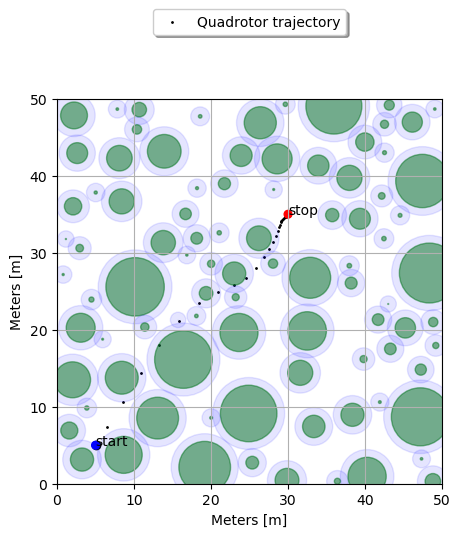

In [23]:
plot_state_trajectory(universe, dir_shooting_states.T)
deviation_from_optimal(dir_shooting_states.T)

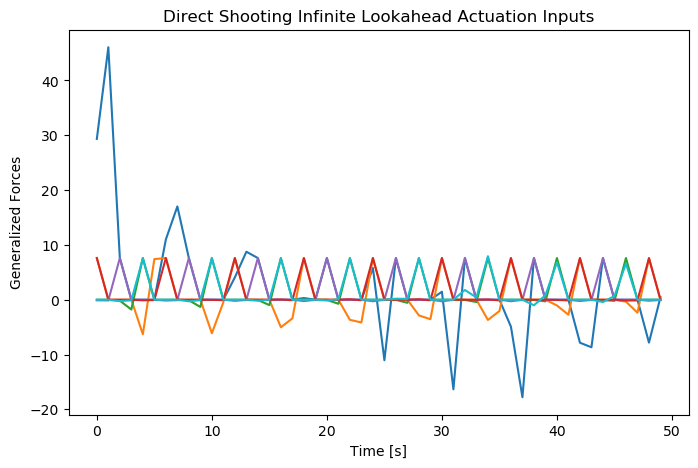

In [42]:
# print(dircol_horizon_input.shape)
thrust_ds = thrust_ds.reshape(input_dim, -1)
x = np.arange(thrust_ds.shape[1])
# print(x)
fig = plt.figure()
plt.title("Direct Shooting Infinite Lookahead Actuation Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Generalized Forces")
plt.plot(x,thrust_ds[0],'tab:blue',x,thrust_ds[1],'tab:orange',x,thrust_ds[2],'tab:green', x,thrust_ds[3],'tab:purple', x,thrust_ds[4],'tab:red', x,thrust_ds[5],'tab:cyan')

In [24]:
def get_subgoal(subuniverse, current_state, goal, horizon_radius):
    """
    Deterimines an intermediate goal for the drone to plan towards
    given the global end and the subuniverse
    """
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(2)  # local end of the subuniverse
    for j, tree in enumerate(subuniverse.forest):
        constraint = prog.AddConstraint(np.sum((x - tree.position)**2) >= (tree.radius)**2) # make local end isn't in a tree + tree_buffer)**2)
        constraint.evaluator().set_description(f"tree_constraint_{j}")
    in_horizon_constraint = prog.AddConstraint(np.sum((x - current_state[0:2])**2) <= horizon_radius**2) # local end within horizon
    in_horizon_constraint.evaluator().set_description("subgoal_in_horizon_constraint")
    distance = x - goal[0:2]
    prog.AddCost(distance[0]**2 + distance[1]**2)
    prog.SetInitialGuess(x, current_state[0:2])
    result = Solve(prog)
    return result.GetSolution(x)

def get_subuniverse(universe, current_state, horizon_radius):
    """
    Determines which trees are within the field of view of the drone
    and creates a subuniverse containing only those trees
    """
    subforest = []
    for tree in universe.forest:
        if np.linalg.norm(current_state[0:2] - tree.position) - (tree.radius) <= horizon_radius: # + tree_buffer in tree.radius paren
            subforest.append(tree)
    subuniverse = Universe(quadrotor, subforest, current_state, None)
    return subuniverse

In [25]:
horizon_radius = 5
at_goal = False
N = 10
time_step_DS = 0.2
full_inputs = np.zeros((input_dim, 0))
full_states = np.zeros((state_dim, 0))

current_state = start
while not at_goal:
    # get the subuniverse - the section of the universe the drone can see
    subuniverse = get_subuniverse(universe, current_state, horizon_radius)
    # determine where the drone should move to within the subuniverse
    subgoal = get_subgoal(subuniverse, current_state, end, horizon_radius)
    subgoal = np.concatenate((subgoal, np.zeros(10))) 
    # set the goal in the subuniverse
    subuniverse.end = subgoal
    print(f"New subgoal: {subgoal}")

    # get the partial trajectory for state and input
    solve_bool, u_trajectory = direct_shooting(subuniverse, N, time_step_DS)
    state = rollout_state(current_state, u_trajectory)
    state = np.array(state).T.reshape((state_dim,-1))
    print(state[:, -1])

    eps = 0.1
    if not solve_bool:
        # roll out to see how close we are
        if (abs(state[:,-1] - subuniverse.end) < np.ones(state_dim)*eps).all():
            print("trajectory really close -- will continue")
        else:
            print("trajectory not close at all")
            print(state[:,-1])
            print(subuniverse.end)

    # add into the whole trajectory
    full_inputs = np.hstack((full_inputs, np.array(u_trajectory).reshape((input_dim,-1))))
    full_states = np.hstack((full_states, state))

    # print(f"Full states: {full_states[:,:3]}")

    last_state = state[:, -1]

    # if we made it to the goal, we are done
    if np.linalg.norm(last_state[0:2] - end[0:2]) < 0.02:
        at_goal = True
    
    current_state = last_state
    print(f"current state: {current_state}")

New subgoal: [8.200922  8.8411064 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
[ 7.21742856  7.66361512 -0.01840988  0.          0.          0.
  0.04818565  0.05782372 -0.47375448  0.          0.          0.        ]
current state: [ 7.21742856  7.66361512 -0.01840988  0.          0.          0.
  0.04818565  0.05782372 -0.47375448  0.          0.          0.        ]
New subgoal: [10.41853719 11.50456599  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
[ 9.43694774 10.32845904 -0.06028338  0.          0.          0.
  0.04793377  0.05754403 -0.47170357  0.          0.          0.        ]
current state: [ 9.43694774 10.32845904 -0.06028338  0.          0.          0.
  0.04793377  0.05754403 -0.47170357  0.          0.          0.        ]
New subgoal: [12.6381853  14.16930245  0.          0.          0.          0.
  0.          0.          0.          0.          0.   

41.598380748313524

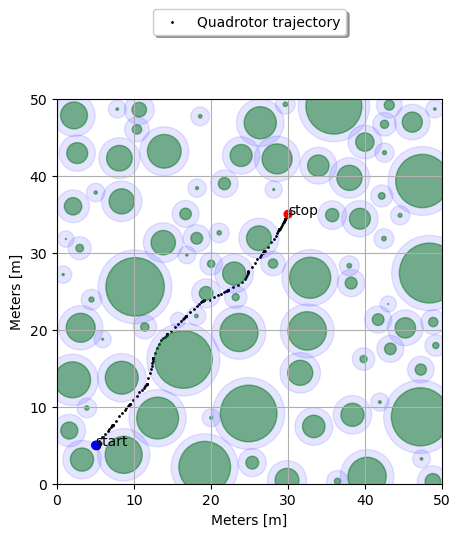

In [26]:
plot_state_trajectory(universe, full_states)
deviation_from_optimal(full_states)

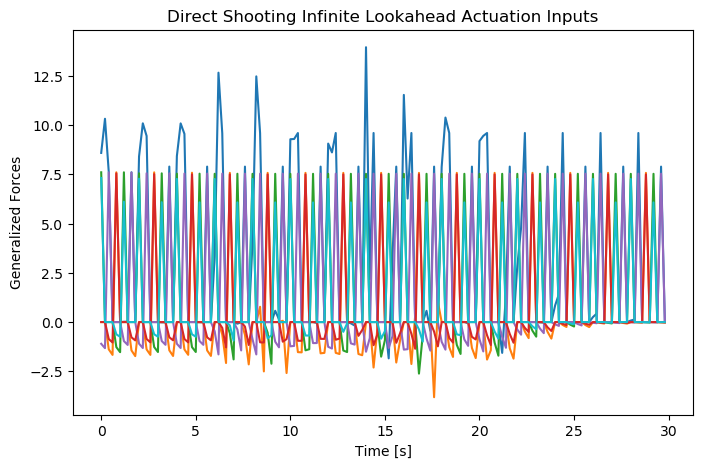

In [39]:
x = np.arange(full_inputs.shape[1])*time_step_DS
# print(x)
fig = plt.figure()
plt.title("Direct Shooting Infinite Lookahead Actuation Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Generalized Forces")
plt.plot(x,full_inputs[0],'tab:blue',x,full_inputs[1],'tab:orange',x,full_inputs[2],'tab:green', x, full_inputs[3],'tab:purple', x,full_inputs[4],'tab:red', x,full_inputs[5],'tab:cyan')

(12, 165)


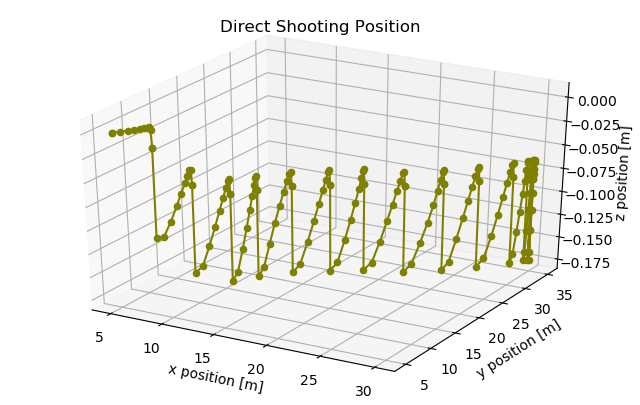

In [48]:
from mpl_toolkits.mplot3d import Axes3D 

# https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-0.0175, 0, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# traj = dir_shooting_states.T
traj = full_states
print(traj.shape)
plt_color = 'olive'
for i in range(traj.shape[-1]):
    # plt_color = lighten_color(plt_color, amount=0.95)
    x = traj[0,i]
    y = traj[1,i]
    z = traj[2,i]
    ax.scatter(x, y, z, marker='o', color = plt_color)

x = traj[0,:]
y = traj[1,:]
z = traj[2,:]
ax.plot(x,y,z, color='olive')


# for tree in universe.forest:
#     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

# Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
# ax.plot_surface(Xc, Yc, Zc, alpha=0.5, color='g')

ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_zlabel('z position [m]')
ax.set_title('Direct Shooting Position')

for angle in range(0, 360*4 + 1):
    # Normalize the angle to the range [-180, 180] for display
    angle_norm = (angle + 180) % 360 - 180

plt.show()

In [18]:
'''
Best run:
 - start @ 5,5 end @ 30, 35

strange things:
- start @ 5,5 end @ 35, 35: direct collocation ran forever and hit max iteration limit
'''

In [19]:
'''
❓ Questions for Russ pt. 2❓
- current status: finite horizon erroring out
-- was working when setting generalized forces
-- switched to propellors --> broke finite horizon
- strange things:
-- no descriptors for constraints
'''

In [20]:
'''
❓ Questions for Russ ❓
- current status: getting gimbal lock because of pitch in finite horizon direct collocation
- prior attempts at fixing:
-- adding constraint on pitch: did not fix because only constrains points and not intermediate states
-- adding cost on pitch: tried this and didn't fix the problem (don't really know why)

- proposed solution: use quaternion instead of RPY
-- constraints exist to enforce quaternion properties: linked in piazza post
-- we could take RPY, convert to quaterion, enforce properties
-- built in dynamics still use RPY, so error could still occur. How to handle this?
'''

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac469912-c1b2-454a-8f77-428a9c7653dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>